In [1]:
%pip install pandas seaborn matplotlib 

You should consider upgrading via the '/Users/tenzin/Desktop/mycodes/nba-draft-ranker/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
from pathlib import Path

current_dir = Path.cwd()
draft_dir = current_dir.parent / "drafts"

files = list(draft_dir.glob("draft_20*.csv"))

draft_df = pd.DataFrame()
for file in files:
    curr_df = pd.read_csv(file)
    draft_df = pd.concat([draft_df, curr_df])

draft_df = draft_df.sort_values(by=["SEASON", "OVERALL_PICK"]) 

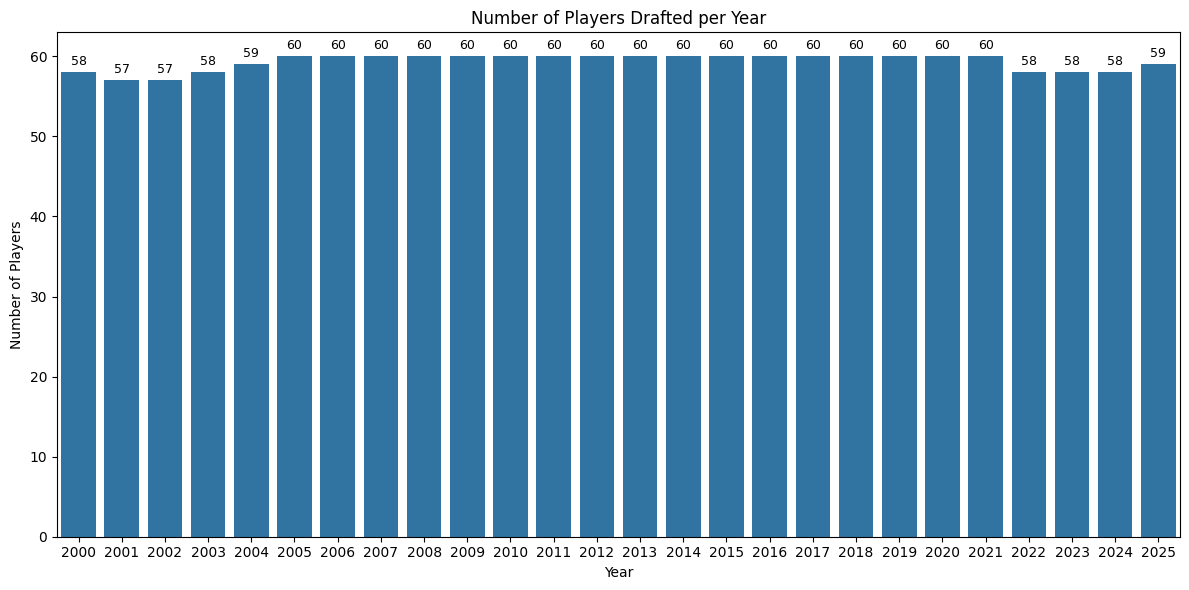

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=draft_df, x="SEASON", ax=ax)
ax.set_title("Number of Players Drafted per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Players")

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        f"{count}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center", va="bottom",
        fontsize=9, xytext=(0, 3), textcoords="offset points"
    )

plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
from pathlib import Path

current_dir = Path.cwd()
draft_combine_dir = current_dir.parent / "draft_combine"

files = list(draft_combine_dir.glob("draft_combine_20*.csv"))

draft_combine_df = pd.DataFrame()
for file in files:
    curr_df = pd.read_csv(file)
    draft_combine_df = pd.concat([draft_combine_df, curr_df])

draft_combine_df = draft_combine_df.sort_values(by=["SEASON"]) 

In [ ]:

# --- merge both datasets (keep all columns from both) ---
merged_df = pd.merge(
    draft_combine_df,
    draft_df,
    left_on=["PLAYER_ID", "SEASON"],
    right_on=["PERSON_ID", "SEASON"],
    how="inner",
    suffixes=("_COMBINE", "_DRAFT")
)

# Remove duplicate rows
merged_df = merged_df.drop_duplicates()
merged_df.to_csv(current_dir.parent /"2000-2025_draft_combines.csv", index=False)

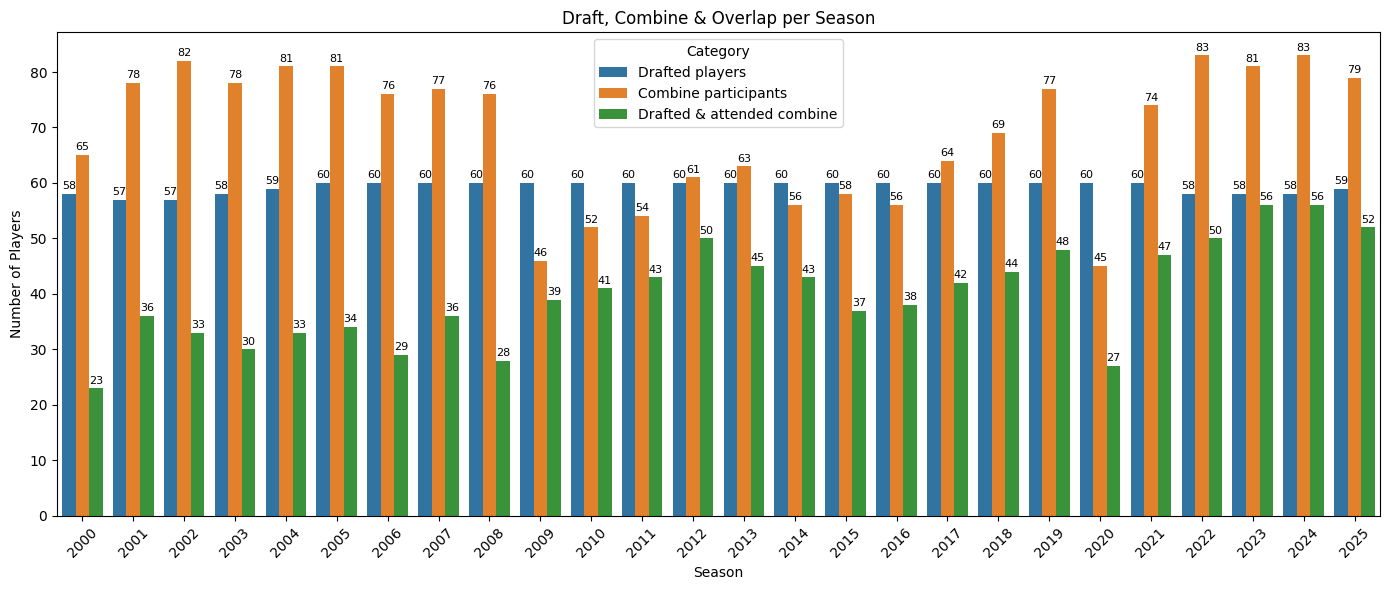

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Counts per season
drafted_counts = (
    draft_df.groupby("SEASON")["PERSON_ID"]
    .nunique()
    .rename("Drafted players")
)

combine_counts = (
    draft_combine_df.groupby("SEASON")["PLAYER_ID"]
    .nunique()
    .rename("Combine participants")
)

drafted_and_combine_counts = (
    merged_df.groupby("SEASON")["PLAYER_ID"]
    .nunique()
    .rename("Drafted & attended combine")
)

# 2) Combine into one DataFrame
counts_per_season = (
    pd.concat(
        [drafted_counts, combine_counts, drafted_and_combine_counts],
        axis=1
    )
    .reset_index()
    .sort_values("SEASON")
)

# 3) Long format for seaborn
plot_df = counts_per_season.melt(
    id_vars="SEASON",
    value_vars=[
        "Drafted players",
        "Combine participants",
        "Drafted & attended combine",
    ],
    var_name="Category",
    value_name="Count",
)

# 4) Plot grouped bar chart
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(
    data=plot_df,
    x="SEASON",
    y="Count",
    hue="Category",
    ax=ax
)

ax.set_title("Draft, Combine & Overlap per Season")
ax.set_xlabel("Season")
ax.set_ylabel("Number of Players")
plt.xticks(rotation=45)

# Optional: label bars with values (matplotlib ≥ 3.4)
for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=2, fontsize=8)

plt.tight_layout()
plt.show()


### Data Preprocessing

In [ ]:
df = merged_df

In [30]:
"""
Purpose: remove duplicate/overlapping columns created by the merge and enforce one row per player-season

1.PLAYER_ID and PERSON_ID are the same after merge -> keep one
2.PLAYER_NAME_COMBINE and PLAYER_NAME_DRAFT are the same -> keep one standardized name

"""
drop_cols = [c for c in ["PERSON_ID", "PLAYER_NAME_DRAFT"] if c in df.columns]
df = df.drop(columns=drop_cols)

if "PLAYER_NAME_COMBINE" in df.columns:
    df = df.rename(columns={"PLAYER_NAME_COMBINE": "PLAYER_NAME"})

# Remove column 'DRAFT_TYPE' since it has only one value
df = df.drop(columns=["DRAFT_TYPE"])

print("Number of duplicates:", df.duplicated().sum())

Number of duplicates: 0


In [33]:
## missing values report

def missing_report(dataframe):
    report = (
        dataframe.isna()
        .sum()
        .to_frame("missing_count")
    )
    report["total_rows"] = len(dataframe)
    report["missing_percent"] = (report["missing_count"] / report["total_rows"]) * 100
    report["non_missing_count"] = report["total_rows"] - report["missing_count"]

    return report[[
        "missing_count",
        "non_missing_count",
        "missing_percent"
    ]].sort_values("missing_percent", ascending=False)


# Example usage:
missing_df = missing_report(df)
missing_df

,missing_count,non_missing_count,missing_percent
OFF_DRIB_COLLEGE_BREAK_RIGHT,1027,13,98.750000
OFF_DRIB_COLLEGE_TOP_KEY,1027,13,98.750000
SPOT_FIFTEEN_CORNER_LEFT,985,55,94.711538
SPOT_FIFTEEN_BREAK_LEFT,984,56,94.615385
SPOT_FIFTEEN_BREAK_RIGHT,984,56,94.615385
SPOT_FIFTEEN_TOP_KEY,984,56,94.615385
SPOT_FIFTEEN_CORNER_RIGHT,984,56,94.615385
SPOT_COLLEGE_CORNER_RIGHT,944,96,90.769231
SPOT_COLLEGE_BREAK_RIGHT,944,96,90.769231
SPOT_COLLEGE_TOP_KEY,944,96,90.769231


In [20]:
# Purpose: extract only "height without shoes" (barefoot height)
# Convert text like "6' 8''" → numeric inches
# Keep one standardized column: HEIGHT (in inches) + optional HEIGHT_CM

import pandas as pd
import re

def ft_in_to_inches(s):
    """Convert strings like 6' 8'' or 6' 8.5'' to inches. Returns None if unparsable."""
    if pd.isna(s):
        return None
    s = str(s)
    m = re.search(r"(\d+)\s*'\s*([\d\.]+)?", s)
    if not m:
        return None
    feet = float(m.group(1))
    inches = float(m.group(2)) if m.group(2) is not None else 0.0
    return round(feet * 12 + inches, 2)

# --- Convert only HEIGHT_WO_SHOES_FT_IN ---
if "HEIGHT_WO_SHOES_FT_IN" in df.columns:
    df["HEIGHT"] = df["HEIGHT_WO_SHOES_FT_IN"].apply(ft_in_to_inches)

# --- Optional: add centimeters version ---
df["HEIGHT_CM"] = df["HEIGHT"] * 2.54

# --- Drop redundant height columns explicitly ---
cols_to_drop = [
    "HEIGHT_WO_SHOES",         # numeric version (duplicate info)
    "HEIGHT_WO_SHOES_FT_IN",   # original text form (we’ve extracted from it)
    "HEIGHT_W_SHOES",          # height with shoes (not needed)
    "HEIGHT_W_SHOES_FT_IN"     # text version with shoes
]
df = df.drop(columns=cols_to_drop, errors="ignore")

# --- Quick verification ---
print(df[["PLAYER_NAME", "HEIGHT", "HEIGHT_CM"]].head())

      PLAYER_NAME  HEIGHT  HEIGHT_CM
0  Jamal Crawford    76.5     194.31
1     Mark Madsen    80.0     203.20
2      Dan Langhi    81.0     205.74
3    Mark Karcher    76.0     193.04
4     Marko Jaric    78.5     199.39


In [21]:
# Purpose: ensure numeric columns are true numbers (floats/ints), not strings

numeric_cols = [
    "HEIGHT_WO_SHOES", "HEIGHT_W_SHOES", "WEIGHT", "WINGSPAN",
    "STANDING_REACH", "BODY_FAT_PCT", "HAND_LENGTH", "HAND_WIDTH",
    "STANDING_VERTICAL_LEAP", "MAX_VERTICAL_LEAP",
    "LANE_AGILITY_TIME", "MODIFIED_LANE_AGILITY_TIME",
    "THREE_QUARTER_SPRINT", "BENCH_PRESS",
    "ROUND_NUMBER", "ROUND_PICK", "OVERALL_PICK", "TEAM_ID", "PLAYER_PROFILE_FLAG"
]
existing_numeric_cols = [c for c in numeric_cols if c in df.columns]
df[existing_numeric_cols] = df[existing_numeric_cols].apply(pd.to_numeric, errors="coerce")

df[existing_numeric_cols].dtypes

WEIGHT                        float64
WINGSPAN                      float64
STANDING_REACH                float64
BODY_FAT_PCT                  float64
HAND_LENGTH                   float64
HAND_WIDTH                    float64
STANDING_VERTICAL_LEAP        float64
MAX_VERTICAL_LEAP             float64
LANE_AGILITY_TIME             float64
MODIFIED_LANE_AGILITY_TIME    float64
THREE_QUARTER_SPRINT          float64
BENCH_PRESS                   float64
ROUND_NUMBER                    int64
ROUND_PICK                      int64
OVERALL_PICK                    int64
TEAM_ID                         int64
PLAYER_PROFILE_FLAG             int64
dtype: object

## Feature Engineering

In [23]:
# Purpose: add useful derived features for downstream analysis or modeling

# BMI = weight (lb) / height^2 (in^2) * 703, using HEIGHT_W_SHOES_INCHES if available
if {"WEIGHT", "HEIGHT"}.issubset(df.columns):
    df["BMI"] = (df["WEIGHT"] / (df["HEIGHT"] ** 2)) * 703

# Vertical ratio: leap relative to height without shoes
if {"MAX_VERTICAL_LEAP", "HEIGHT"}.issubset(df.columns):
    df["VERTICAL_RATIO"] = df["MAX_VERTICAL_LEAP"] / df["HEIGHT"]

### Correlation with Player's Physical Attributes with Player's Draft Pick

In [ ]:
# Purpose: visualize overall correlation structure among key combine metrics and draft order
# (lower OVERALL_PICK = better player)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Select meaningful features ---
corr_features = [
    "OVERALL_PICK",
    "HEIGHT", "HEIGHT_CM", "WEIGHT", "WINGSPAN",
    "BODY_FAT_PCT", "BMI",
    "STANDING_VERTICAL_LEAP", "MAX_VERTICAL_LEAP",
    "LANE_AGILITY_TIME", "THREE_QUARTER_SPRINT", "BENCH_PRESS"
]

# --- Filter to existing columns ---
corr_features = [c for c in corr_features if c in df.columns]
corr_df = df[corr_features].dropna()

# --- Compute correlation matrix ---
corr_matrix = corr_df.corr(numeric_only=True)

# --- Plot heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap — Combine Metrics and Draft Order (Pearson r)", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

- Size metrics (height, weight, wingspan) correlate strongly with each other but weakly with draft order.  
- Body fat shows slight positive relation with later picks.  
- Overall, combine stats show little linear link to draft position.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

core_features = [
    "OVERALL_PICK", "HEIGHT", "WEIGHT", "WINGSPAN", "BODY_FAT_PCT", "BMI",
    "STANDING_VERTICAL_LEAP", "MAX_VERTICAL_LEAP",
    "LANE_AGILITY_TIME", "THREE_QUARTER_SPRINT", "BENCH_PRESS"
]

sns.pairplot(df[core_features].dropna(), diag_kind="kde", corner=True)
plt.suptitle("Pairwise Relationships of Combine Metrics vs Draft Pick", y=1.02)
plt.show()


In [ ]:
spearman_corr = df[core_features].corr(method="spearman", numeric_only=True)["OVERALL_PICK"].sort_values()
plt.figure(figsize=(8,5))
plt.barh(spearman_corr.index, spearman_corr.values, color="tab:blue")
plt.title("Spearman Rank Correlation with Draft Order")
plt.xlabel("Spearman ρ (monotonic relationship)")
plt.axvline(0, color="black", lw=1)
plt.tight_layout()
plt.show()


_This Spearman chart confirms what the pairplot hinted — raw physical combine numbers have almost no monotonic relationship with draft position overall._

In [ ]:
# Count plot of values based on column "ROUND_NUMBER"
import seaborn as sns
import matplotlib.pyplot as plt

# Count plot of values based on column "ROUND_NUMBER"
sns.countplot(x="ROUND_NUMBER", data=df)
plt.show()


In [ ]:
# Purpose: Save descriptive statistics of physical attributes for Round 1 and Round 2 to CSV

import pandas as pd
from pathlib import Path

# --- Ensure round is numeric ---
df["ROUND_NUMBER"] = pd.to_numeric(df["ROUND_NUMBER"], errors="coerce")

# --- Define physical / athletic feature set ---
physical_features = [
    "HEIGHT", "HEIGHT_CM", "WEIGHT", "WINGSPAN",
    "BODY_FAT_PCT", "BMI",
    "STANDING_VERTICAL_LEAP", "MAX_VERTICAL_LEAP",
    "LANE_AGILITY_TIME", "THREE_QUARTER_SPRINT", "BENCH_PRESS"
]
physical_features = [f for f in physical_features if f in df.columns]

# --- Split by round ---
round1_df = df[df["ROUND_NUMBER"] == 1][physical_features]
round2_df = df[df["ROUND_NUMBER"] == 2][physical_features]

# --- Compute descriptive stats ---
desc_round1 = round1_df.describe().T
desc_round2 = round2_df.describe().T

# --- Add round labels ---
desc_round1["ROUND"] = "Round 1"
desc_round2["ROUND"] = "Round 2"

# --- Combine for comparison ---
compare_desc = pd.concat([desc_round1, desc_round2])
compare_desc = compare_desc[["ROUND", "count", "mean", "std", "min", "25%", "50%", "75%", "max"]]

# --- Save to CSV ---
output_path = Path("draft_physical_stats_comparison.csv")
compare_desc.to_csv(output_path, index_label="Feature")

print(f"✅ Descriptive comparison saved to: {output_path.resolve()}")


## Player Position

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="POSITION", y="OVERALL_PICK")
plt.title("Draft Pick Distribution by Position")
plt.ylabel("Overall Pick (Lower = Earlier)")
plt.xlabel("Position")
plt.gca().invert_yaxis()  # smaller = better
plt.show()


In [ ]:
# Purpose: Clean player position labels using defined priority hierarchy

import pandas as pd
import re

# --- Define position priority (lower index = higher priority) ---
position_priority = ["PG", "SG", "SF", "PF", "C"]
position_rank = {pos: i for i, pos in enumerate(position_priority)}

def clean_position(pos):
    """Normalize multi-position strings to the highest-priority position."""
    if pd.isna(pos):
        return None
    # Split by '-' or '/' or ',' and uppercase all
    parts = re.split(r'[-/, ]+', str(pos).upper())
    parts = [p for p in parts if p in position_rank]
    if not parts:
        return None
    # Pick position with smallest priority rank
    return sorted(parts, key=lambda p: position_rank[p])[0]

# --- Apply cleaning ---
df["POSITION_CLEAN"] = df["POSITION"].apply(clean_position)

# --- Verify result ---
print(df[["POSITION", "POSITION_CLEAN"]].drop_duplicates().sort_values("POSITION_CLEAN").head(20))

# --- Optional: visualize cleaned positions ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="POSITION_CLEAN", y="OVERALL_PICK", order=position_priority)
plt.gca().invert_yaxis()
plt.title("Draft Pick Distribution by Cleaned Position")
plt.xlabel("Position")
plt.ylabel("Overall Pick (Lower = Earlier)")
plt.tight_layout()
plt.show()


In [ ]:
# Purpose: Simplify cleaned positions into broad groups (G, F, C)

# --- Define mapping from detailed to broad position groups ---
group_map = {
    "PG": "G",
    "SG": "G",
    "SF": "F",
    "PF": "F",
    "C": "C"
}

# --- Apply grouping ---
df["POSITION_GROUP"] = df["POSITION_CLEAN"].map(group_map)

# --- Verify result ---
print(df[["POSITION", "POSITION_CLEAN", "POSITION_GROUP"]].drop_duplicates().sort_values("POSITION_GROUP"))

# --- Optional: visualize grouped positions ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# --- Subplot 1: Boxplot (distribution of picks per position group) ---
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x="POSITION_GROUP", y="OVERALL_PICK", order=order, palette="Set2")
plt.gca().invert_yaxis()  # lower = earlier pick
plt.title("Draft Pick Distribution by Position Group")
plt.xlabel("Position Group")
plt.ylabel("Overall Pick (Lower = Earlier)")

# --- Subplot 2: Barplot (average draft pick per position group) ---
plt.subplot(1, 2, 2)
avg_pick = df.groupby("POSITION_GROUP")["OVERALL_PICK"].mean().reindex(order)
sns.barplot(x=avg_pick.index, y=avg_pick.values, palette="Set2")
plt.gca().invert_yaxis()
for i, val in enumerate(avg_pick.values):
    plt.text(i, val + 1, f"{val:.1f}", ha="center", va="bottom", fontsize=9)
plt.title("Average Draft Pick by Position Group")
plt.xlabel("Position Group")
plt.ylabel("Mean Overall Pick")

plt.tight_layout()
plt.show()


### Correlation btwn position and draft pick

In [ ]:
# Purpose: Plot average draft pick by position group across seasons

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure data types
df["SEASON"] = pd.to_numeric(df["SEASON"], errors="coerce")
df["POSITION_GROUP"] = df["POSITION_GROUP"].astype("category")

# --- Compute yearly averages ---
avg_pick_yearly = (
    df.groupby(["SEASON", "POSITION_GROUP"])["OVERALL_PICK"]
    .mean()
    .reset_index()
)

# --- Plot ---
plt.figure(figsize=(12,6))
sns.lineplot(
    data=avg_pick_yearly,
    x="SEASON", y="OVERALL_PICK", hue="POSITION_GROUP",
    marker="o", palette="Set2"
)
plt.gca().invert_yaxis()  # lower pick = better
plt.title("Average Draft Pick by Position Group per Year", fontsize=14)
plt.xlabel("Draft Year (Season)")
plt.ylabel("Average Draft Pick (Lower = Earlier)")
plt.legend(title="Position Group", loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Across seasons, the average draft pick positions for Guards (G), Forwards (F), and Centers (C) fluctuate but follow a consistent pattern — Guards (G) are generally drafted earlier, followed closely by Forwards (F), while Centers (C) show greater variability and occasional peaks of earlier selections (e.g., years with standout big men).
This suggests that backcourt players tend to be prioritized more consistently, while the demand for Centers varies by draft class strength and team needs.

## Train Model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# --- Features & Target ---
features = [
    "HEIGHT", "HEIGHT_CM", "WEIGHT", "WINGSPAN",
    "BODY_FAT_PCT", "BMI",
    "STANDING_VERTICAL_LEAP", "MAX_VERTICAL_LEAP",
    "LANE_AGILITY_TIME", "THREE_QUARTER_SPRINT", "BENCH_PRESS",
    "POSITION_GROUP"   # <-- categorical
]
target = "OVERALL_PICK"

df_model = df[features + [target]].dropna(subset=[target])

# --- Split ---
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Separate numeric and categorical columns
num_cols = [c for c in features if c != "POSITION_GROUP"]
cat_cols = ["POSITION_GROUP"]

# Preprocess
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(drop="first"))  # avoid dummy trap
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


In [ ]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(random_state=42))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


In [ ]:
from itertools import combinations
import numpy as np
from scipy.stats import kendalltau, spearmanr

def ranking_metrics(y_true, y_pred, max_pairs=50000, random_state=42):
    """
    Evaluate ranking quality.
    Returns: pairwise_accuracy, kendall_tau, spearman_r
    """
    rng = np.random.default_rng(random_state)
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    n = len(y_true)
    # sample pairs without replacement (upper bound = nC2)
    all_pairs = np.array(list(combinations(range(n), 2)))
    if len(all_pairs) > max_pairs:
        idx = rng.choice(len(all_pairs), size=max_pairs, replace=False)
        pairs = all_pairs[idx]
    else:
        pairs = all_pairs

    i = pairs[:,0]
    j = pairs[:,1]

    # True order: earlier pick = smaller number (so "better")
    true_less = y_true[i] < y_true[j]
    pred_less = y_pred[i] < y_pred[j]

    # ignore ties in either true or pred
    non_tie_mask = (y_true[i] != y_true[j]) & (y_pred[i] != y_pred[j])
    acc = (true_less[non_tie_mask] == pred_less[non_tie_mask]).mean()

    # Rank correlations (monotonic agreement for full arrays)
    ktau, _ = kendalltau(y_true, y_pred)
    s_rho, _ = spearmanr(y_true, y_pred)

    return acc, ktau, s_rho

# ---- After you computed y_pred on X_test ----
pair_acc, ktau, s_rho = ranking_metrics(y_test, y_pred, max_pairs=50000)

print(f"Pairwise ranking accuracy: {pair_acc:.3f}")
print(f"Kendall's tau: {ktau:.3f}")
print(f"Spearman rho:  {s_rho:.3f}")


In [ ]:
def compare_players(player1, player2):
    df_pair = pd.DataFrame([player1, player2])
    preds = model.predict(df_pair)
    winner = "Player 1" if preds[0] < preds[1] else "Player 2"
    
    print(f"Predicted Draft Pick — Player 1: {preds[0]:.1f}, Player 2: {preds[1]:.1f}")
    print(f"➡️ Model predicts {winner} would be drafted earlier.")


In [ ]:
compare_players(
    {"HEIGHT": 78, "HEIGHT_CM": 198, "WEIGHT": 210, "WINGSPAN": 82,
     "BODY_FAT_PCT": 6.5, "BMI": 24.5, "STANDING_VERTICAL_LEAP": 30,
     "MAX_VERTICAL_LEAP": 35, "LANE_AGILITY_TIME": 11.2,
     "THREE_QUARTER_SPRINT": 3.2, "BENCH_PRESS": 12, "POSITION_GROUP": "G"},
    
    {"HEIGHT": 82, "HEIGHT_CM": 208, "WEIGHT": 230, "WINGSPAN": 86,
     "BODY_FAT_PCT": 8.2, "BMI": 26.8, "STANDING_VERTICAL_LEAP": 28,
     "MAX_VERTICAL_LEAP": 33, "LANE_AGILITY_TIME": 11.5,
     "THREE_QUARTER_SPRINT": 3.4, "BENCH_PRESS": 10, "POSITION_GROUP": "C"}
)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract importance from trained model
model_final = model.named_steps["regressor"]
feature_names = (
    num_cols + 
    list(model.named_steps["preprocessor"]
         .named_transformers_["cat"]
         .named_steps["encoder"]
         .get_feature_names_out(cat_cols))
)
importances = model_final.feature_importances_

fi = pd.DataFrame({"Feature": feature_names, "Importance": importances})
fi = fi.sort_values("Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=fi)
plt.title("Feature Importance — Draft Order Prediction (with Position)")
plt.tight_layout()
plt.show()
